In [1]:
from utils import *

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])

## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

In [8]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

## 4. Modeling

In [9]:
X = train_df.drop(['sub_area', 'price_doc'], axis=1).copy()
y = train_df['price_doc']
X_test = test_df.drop(['sub_area'], axis=1).copy()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((22152, 293), (5539, 293))

In [11]:
params = {'n_estimators': 1000,
          'base_score': 7000000,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.05,
          # 'reg_alpha': 30,
          # 'min_child_weight': 10,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'seed': 42,
          'nthread': -1
          }

model = XGBRegressor(objective='reg:squarederror', **params)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)


[0]	validation_0-mae:2470663.75000	validation_1-mae:2543995.25000
[1]	validation_0-mae:2376858.75000	validation_1-mae:2445772.75000
[2]	validation_0-mae:2290414.75000	validation_1-mae:2355354.75000
[3]	validation_0-mae:2220759.75000	validation_1-mae:2283761.00000
[4]	validation_0-mae:2146534.50000	validation_1-mae:2205638.25000
[5]	validation_0-mae:2083004.75000	validation_1-mae:2139951.75000
[6]	validation_0-mae:2014869.00000	validation_1-mae:2067530.75000
[7]	validation_0-mae:1952070.50000	validation_1-mae:2002379.62500
[8]	validation_0-mae:1893061.50000	validation_1-mae:1941003.50000
[9]	validation_0-mae:1835635.87500	validation_1-mae:1881135.50000
[10]	validation_0-mae:1780353.75000	validation_1-mae:1824617.87500
[11]	validation_0-mae:1730344.00000	validation_1-mae:1772462.62500
[12]	validation_0-mae:1682432.37500	validation_1-mae:1723730.50000
[13]	validation_0-mae:1638221.00000	validation_1-mae:1678484.50000
[14]	validation_0-mae:1596247.37500	validation_1-mae:1635524.75000
[15]	

XGBRegressor(base_score=7000000, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='mae',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=-1,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
1.287

1.287

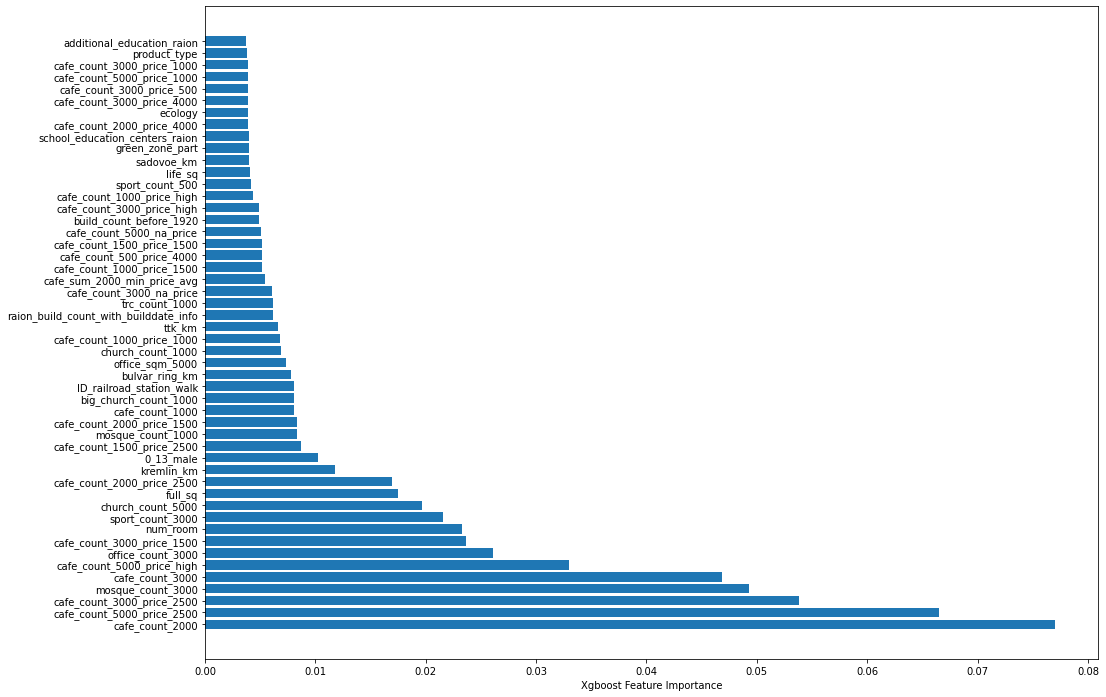

In [15]:
plt.figure(figsize=(16, 12))
sorted_idx = model.feature_importances_.argsort()[::-1]
plt.barh(X.columns[sorted_idx[:50]], model.feature_importances_[sorted_idx[:50]])
plt.xlabel("Xgboost Feature Importance");

In [14]:
raise StopIteration

StopIteration: 

In [16]:
y_pred_train = np.abs(model.predict(X_train))
y_pred_val = np.abs(model.predict(X_val))
print('      TRAIN:', np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
print('VALIDATION :', np.sqrt(mean_squared_log_error(y_val, y_pred_val)))

      TRAIN: 0.1156383620447182
VALIDATION : 0.16336664103889187


In [17]:
create_submission(model, X_test)

In [21]:
submission = pd.read_csv('data/sample_submission.csv')
pred = model.predict(X_test)
if len(pred[pred < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')
    pred = np.abs(pred)
submission['price_doc'] = pred * 0.85
submission.to_csv('submission.csv', index=False)


In [22]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "XGBRegressor w/out outliers"

100%|████████████████████████████████████████| 121k/121k [00:02<00:00, 60.7kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [ ]:
# !kaggle competitions submissions -c sberbank-russian-housing-market